In [77]:
# estatísticas básicas
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



file_name = 'measurements.csv'
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".")
df['Language'].replace('CSharp', 'C#', inplace=True)
df.head()

,Language,Program,PowerLimit,Package,Core,GPU,DRAM,Time,Temperature,Memory
0,Ada,binary-trees,-1,111.164307,83.531372,0.000000,10.218201,2930.0,30.2,202916
1,Ada,binary-trees,-1,104.618347,78.319946,0.000000,9.582825,2786.0,30.2,202912
2,Ada,binary-trees,-1,103.557495,76.979980,0.000854,9.681396,2815.0,31.2,203216
3,Ada,binary-trees,-1,105.154663,79.431458,0.000000,9.418457,2731.0,32.5,203136
4,Ada,binary-trees,-1,104.885132,78.551208,0.000000,9.657104,2784.0,32.2,203208


In [78]:
df = df[df['Time'] != 'error']

In [79]:
# List of variables to be cast to float
variables_to_cast = ['Package', 'Core', 'GPU', 'DRAM', 'Time', 'Temperature', 'Memory']

# Iterate through the specified variables and cast them to float
for variable in variables_to_cast:
    df[variable] = pd.to_numeric(df[variable], errors='coerce').astype(float)

df['Program'] = df['Program'].str.lstrip()
# Display the modified DataFrame
df.head()


,Language,Program,PowerLimit,Package,Core,GPU,DRAM,Time,Temperature,Memory
0,Ada,binary-trees,-1,111.164307,83.531372,0.000000,10.218201,2930.0,30.2,202916.0
1,Ada,binary-trees,-1,104.618347,78.319946,0.000000,9.582825,2786.0,30.2,202912.0
2,Ada,binary-trees,-1,103.557495,76.979980,0.000854,9.681396,2815.0,31.2,203216.0
3,Ada,binary-trees,-1,105.154663,79.431458,0.000000,9.418457,2731.0,32.5,203136.0
4,Ada,binary-trees,-1,104.885132,78.551208,0.000000,9.657104,2784.0,32.2,203208.0


In [80]:
df.dtypes

Language        object
Program         object
PowerLimit       int64
Package        float64
Core           float64
GPU            float64
DRAM           float64
Time           float64
Temperature    float64
Memory         float64
dtype: object

# Analise dos dados

In [81]:
dfAnalise = df.drop(['GPU', 'Core','DRAM'], axis=1)

In [82]:
dfAnalise.shape[0]

20899

## Tratamento

### Remover extremos

In [83]:
group_columns = ['Language', 'Program','PowerLimit']
value_column = 'Package'
n_values_to_remove = 3

# Define a function to remove the lowest and highest values within each group
def remove_extremes(group):
    sorted_group = group.sort_values(value_column)
    return sorted_group.iloc[n_values_to_remove:-n_values_to_remove]

# Apply the function within each group using groupby with multiple columns
dfAnalise = dfAnalise.groupby(group_columns, group_keys=False, sort=False).apply(remove_extremes)

In [84]:
dfAnalise.shape[0]

14629

### Remoção de linguagens que não têm todas as execuções

In [85]:
#Remoção do pidits e do Lisp (tem uma execução inválida)
dfAnalise = dfAnalise[dfAnalise['Program'] != 'pidigits']
dfAnalise = dfAnalise[dfAnalise['Language'] != 'Lisp']

In [86]:
languagesProgramImplm = {}
for language, group in dfAnalise.groupby('Language'):
    programs = group['Program'].unique().tolist()
    languagesProgramImplm[language] = programs
for language in languagesProgramImplm:
    print(language, " -> " , languagesProgramImplm[language])

Ada  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C#  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C++  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
Dart  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
Erlang  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
FSharp  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'spect

In [87]:
for language in languagesProgramImplm:
    languagesProgramImplm[language] = len(languagesProgramImplm[language])
    print(language, " -> " , languagesProgramImplm[language])

Ada  ->  9
C  ->  9
C#  ->  9
C++  ->  9
Dart  ->  9
Erlang  ->  9
FSharp  ->  8
Go  ->  9
Haskell  ->  9
Java  ->  9
JavaScript  ->  9
Julia  ->  9
Lua  ->  9
OCaml  ->  9
PHP  ->  9
Pascal  ->  8
Perl  ->  9
Python  ->  9
Racket  ->  9
Ruby  ->  9
Rust  ->  9
Swift  ->  9


In [88]:
dfAnalise = dfAnalise[dfAnalise['Language'] != 'FSharp']
dfAnalise = dfAnalise[dfAnalise['Language'] != 'Pascal']

## Analise

### Verificar em média qual é o powerlimit em que obtivemos melhores resultados

#### Each Language-Program best PowerLimit value minimize Package

In [89]:
group_columns = ['Language', 'Program','PowerLimit']
#languages = dfAnalise.groupby('Language', group_keys=False, sort=False)

dfBestPower = dfAnalise.groupby(group_columns)['Package'].mean().reset_index(name='Package')

# Sort the DataFrame by 'Package' in ascending order
dfBestPower = dfBestPower.sort_values(by='Package')

# Keep only the first row for each combination of 'Language' and 'Program'
dfBestPower = dfBestPower.groupby(['Language', 'Program']).first().reset_index()

# Display the result
dfBestPower.head(10)

,Language,Program,PowerLimit,Package
0,Ada,binary-trees,15,91.781001
1,Ada,fannkuch-redux,25,252.235151
2,Ada,fasta,15,44.793296
3,Ada,k-nucleotide,15,132.811859
4,Ada,mandelbrot,15,114.203156
5,Ada,n-body,15,93.959494
6,Ada,regex-redux,15,116.835994
7,Ada,reverse-complement,15,6.980277
8,Ada,spectral-norm,15,27.099095
9,C,binary-trees,15,36.662851


#### PowerLimit mode for each Language

In [90]:
# Group by 'Language' and calculate the mode for 'PowerLimit'
dfBestPower = dfBestPower.groupby('Language')['PowerLimit'].apply(lambda x: x.mode().iloc[0]).reset_index()
print(dfBestPower)

#With this table we can see that PowerLimit at 15 is the value that saves the most energy

      Language  PowerLimit
0          Ada          15
1            C          15
2           C#          15
3          C++          15
4         Dart          15
5       Erlang          15
6           Go          15
7      Haskell          15
8         Java          15
9   JavaScript          15
10       Julia          15
11         Lua          15
12       OCaml          15
13         PHP          15
14        Perl          15
15      Python          15
16      Racket          15
17        Ruby          15
18        Rust          15
19       Swift          15


### Ranking de Linguagens

#### Default Ranking Calculation

In [91]:
dfRanking = dfAnalise[['Language','Program','PowerLimit','Package','Time']]
dfRanking = dfRanking[dfRanking['PowerLimit'].isin([-1,15])]
dfRanking.rename(columns={'Package': 'Energy (J)'}, inplace=True)
dfRanking.rename(columns={'Time': 'Time (ms)'}, inplace=True)
dfRanking.head(5)

,Language,Program,PowerLimit,Energy (J),Time (ms)
1,Ada,binary-trees,-1,104.618347,2786.0
4,Ada,binary-trees,-1,104.885132,2784.0
7,Ada,binary-trees,-1,104.973206,2787.0
11,Ada,binary-trees,-1,105.053101,2803.0
3,Ada,binary-trees,-1,105.154663,2731.0


#### Calcular Médias

In [92]:
dfRanking = dfRanking.groupby(['Language', 'Program', 'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()
dfRanking.head(10)

,Language,Program,PowerLimit,Energy (J),Time (ms)
0,Ada,binary-trees,-1,105.951338,2758.571429
1,Ada,binary-trees,15,91.781001,6143.857143
2,Ada,fannkuch-redux,-1,291.102408,6745.642857
3,Ada,fannkuch-redux,15,252.640887,16904.071429
4,Ada,fasta,-1,46.433668,2488.428571
5,Ada,fasta,15,44.793296,2994.785714
6,Ada,k-nucleotide,-1,152.395438,5584.500000
7,Ada,k-nucleotide,15,132.811859,8887.642857
8,Ada,mandelbrot,-1,128.673113,3625.357143
9,Ada,mandelbrot,15,114.203156,7640.714286


In [93]:
dataset_power_no_limit = dfRanking[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
dataset_power_limit_15 = dfRanking[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])

#### Ranking with not limitations

In [94]:
# Create a dictionary to store the sorted DataFrames for each program
dict_no_limit = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_no_limit.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_no_limit[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in dict_no_limit.items():
    print(f"Program: {program}")
    print(sorted_df[['Language', 'Energy (J)', 'Time (ms)']])  # Exclude 'Program' and 'PowerLimit' columns
    print("\n")


Program: binary-trees
      Language   Energy (J)     Time (ms)
0          C++    37.163199    893.000000
1         Rust    42.265533    964.571429
2            C    43.835545   1058.785714
3      Haskell    60.254364   1857.642857
4         Java    89.930385   2248.571429
5          Ada   105.951338   2758.571429
6       Racket   117.075819   4071.857143
7        OCaml   134.281010   3748.000000
8       Erlang   143.844596   3883.142857
9   JavaScript   233.266545   5858.785714
10        Dart   342.165327  10684.357143
11       Julia   392.303192  14458.428571
12          C#   434.780404  24638.500000
13       Swift   471.039804  12427.142857
14          Go   558.222229  11859.000000
15         PHP   858.226889  20664.428571
16        Ruby  1146.264487  29184.571429
17        Perl  1544.168588  34020.571429
18      Python  1577.558759  36424.357143
19         Lua  1821.557970  43666.357143


Program: fannkuch-redux
      Language    Energy (J)      Time (ms)
0            C     82.8381

#### Ranking with PowerLimit 15

In [95]:
#Fazer o dicionário
# Create a dictionary to store the sorted DataFrames for each program
dict_limit_15 = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_limit_15.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_limit_15[program] = sorted_df

In [96]:
# Initialize an empty list to store the comparison results
comparison_results = []

# Iterate over programs in the first dictionary
for program, df1 in dict_limit_15.items():
    # Check if the program exists in the second dictionary
    if program in dict_no_limit:
        df2 = dict_no_limit[program]

        # Iterate over languages in the program
        for language in df1['Language']:
            # Extract data for the specific language in both dictionaries
            lang_df1 = df1[df1['Language'] == language]
            lang_df2 = df2[df2['Language'] == language]

            # Calculate the differences
            position_changes = lang_df1.index[0] - lang_df2.index[0]
            energy_difference = lang_df1['Energy (J)'].iloc[0] - lang_df2['Energy (J)'].iloc[0]
            time_difference = lang_df1['Time (ms)'].iloc[0] - lang_df2['Time (ms)'].iloc[0]

            # Append the results to the comparison list
            comparison_results.append({
                'Program': program,
                'Language': language,
                'Energy (J)': lang_df1['Energy (J)'].iloc[0],
                'Time (ms)': lang_df1['Time (ms)'].iloc[0],
                'Position Changes': position_changes,
                'Energy Difference': energy_difference,
                'Energy Difference %': energy_difference/lang_df2['Energy (J)'].iloc[0]*100,
                'Time Difference': time_difference,
                'Time Difference %': time_difference/lang_df2['Time (ms)'].iloc[0]*100
            })

# Convert the list of dictionaries into a DataFrame
dataset_power_limit_15 = pd.DataFrame(comparison_results)

# Display the comparison results
dataset_power_limit_15.head(10)

,Program,Language,Energy (J),Time (ms),Position Changes,Energy Difference,Energy Difference %,Time Difference,Time Difference %
0,binary-trees,C++,31.039503,2075.428571,0,-6.123696,-16.477851,1182.428571,132.410814
1,binary-trees,Rust,36.037733,2411.000000,0,-6.227801,-14.734939,1446.428571,149.955569
2,binary-trees,C,36.662851,2452.928571,0,-7.172695,-16.362736,1394.142857,131.673750
3,binary-trees,Haskell,51.612270,3586.571429,0,-8.642094,-14.342686,1728.928571,93.071096
4,binary-trees,Java,65.531974,4388.142857,0,-24.398411,-27.130331,2139.571429,95.152478
5,binary-trees,Ada,91.781001,6143.857143,0,-14.170336,-13.374381,3385.285714,122.718799
6,binary-trees,Racket,96.313184,6485.714286,0,-20.762634,-17.734349,2413.857143,59.281479
7,binary-trees,OCaml,113.276838,7577.285714,0,-21.004172,-15.641953,3829.285714,102.168776
8,binary-trees,Erlang,119.406987,8212.642857,0,-24.437609,-16.988896,4329.500000,111.494739
9,binary-trees,JavaScript,193.514417,12949.000000,0,-39.752128,-17.041504,7090.214286,121.018495


In [97]:
# Gera o dataframe com os ganhos percentuais de um problema em todas as linguagens de programação
prog = "spectral-norm"
_dataset_power_limit_15_ = dataset_power_limit_15.round(2)

# Filtrando as colunas desejadas
#_dataset_power_limit_15_ = _dataset_power_limit_15_[["Program", "Language", "Energy Difference", "Energy Difference %", "Time Difference", "Time Difference %"]]
_dataset_power_limit_15_ = _dataset_power_limit_15_[["Program", "Language", "Energy Difference %", "Time Difference %"]]


# Ordem desejada para a coluna "Language"
language_order = ["Ada", "C", "C++", "C#", "Dart", "Erlang", "Go", "Haskell", "Java", "JavaScript", "Julia", "Lua", "OCaml", "Perl", "PHP", "Python", "Racket", "Ruby", "Rust", "Swift"]

# Reordenando o DataFrame com base na ordem desejada da coluna "Language"
_dataset_power_limit_15_ = _dataset_power_limit_15_.set_index("Language").loc[language_order].reset_index()

_dataset_power_limit_15_[_dataset_power_limit_15_["Program"] == prog]

,Language,Program,Energy Difference %,Time Difference %
8,Ada,spectral-norm,-18.88,164.46
17,C,spectral-norm,-13.31,151.46
26,C++,spectral-norm,-8.50,97.28
35,C#,spectral-norm,-17.19,95.90
44,Dart,spectral-norm,-11.34,95.37
53,Erlang,spectral-norm,-15.75,164.82
62,Go,spectral-norm,-8.86,96.81
71,Haskell,spectral-norm,-7.72,94.16
80,Java,spectral-norm,-8.06,94.06
89,JavaScript,spectral-norm,-8.28,96.55


In [98]:
#Fazer o dicionário
# Create a dictionary to store the sorted DataFrames for each program
dict_limit_15 = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_limit_15.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_limit_15[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in dict_limit_15.items():
    print(f"Program: {program}")
    print(sorted_df.drop(columns=['Program']))
    print("\n")

Program: binary-trees
      Language   Energy (J)     Time (ms)  Position Changes  \
0          C++    31.039503   2075.428571                 0   
1         Rust    36.037733   2411.000000                 0   
2            C    36.662851   2452.928571                 0   
3      Haskell    51.612270   3586.571429                 0   
4         Java    65.531974   4388.142857                 0   
5          Ada    91.781001   6143.857143                 0   
6       Racket    96.313184   6485.714286                 0   
7        OCaml   113.276838   7577.285714                 0   
8       Erlang   119.406987   8212.642857                 0   
9   JavaScript   193.514417  12949.000000                 0   
10        Dart   283.220912  19026.285714                 0   
11       Julia   344.259992  23064.571429                 0   
12       Swift   408.260991  27308.500000                -1   
13          C#   413.741503  31149.928571                 1   
14          Go   462.370623  3092

In [99]:
dfRanking_dict = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dfRanking.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dfRanking_dict[program] = sorted_df

In [100]:
problem = "binary-trees"
singleProblemDF = dfRanking_dict[problem]
singleProblemDF['Type'] = "undefined"

In [101]:
singleProblemDF.loc[singleProblemDF['Language'] == 'Ada', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'C', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'C++', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'Go', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'Haskell', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'OCaml', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'Rust', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'Swift', 'Type'] = "Compiled"

In [102]:
singleProblemDF.loc[singleProblemDF['Language'] == 'Dart', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'JavaScript', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Lua', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Perl', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'PHP', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Python', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Ruby', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Julia', 'Type'] = "Interpreted"

In [103]:
singleProblemDF.loc[singleProblemDF['Language'] == 'C#', 'Type'] = "Virtual Machine"
singleProblemDF.loc[singleProblemDF['Language'] == 'Erlang', 'Type'] = "Virtual Machine"
singleProblemDF.loc[singleProblemDF['Language'] == 'Java', 'Type'] = "Virtual Machine"
singleProblemDF.loc[singleProblemDF['Language'] == 'Racket', 'Type'] = "Virtual Machine"

In [104]:
singleProblemDF.head(40)

,Language,Program,PowerLimit,Energy (J),Time (ms),Type
0,C++,binary-trees,15,31.039503,2075.428571,Compiled
1,Rust,binary-trees,15,36.037733,2411.000000,Compiled
2,C,binary-trees,15,36.662851,2452.928571,Compiled
3,C++,binary-trees,-1,37.163199,893.000000,Compiled
4,Rust,binary-trees,-1,42.265533,964.571429,Compiled
5,C,binary-trees,-1,43.835545,1058.785714,Compiled
6,Haskell,binary-trees,15,51.612270,3586.571429,Compiled
7,Haskell,binary-trees,-1,60.254364,1857.642857,Compiled
8,Java,binary-trees,15,65.531974,4388.142857,Virtual Machine
9,Java,binary-trees,-1,89.930385,2248.571429,Virtual Machine


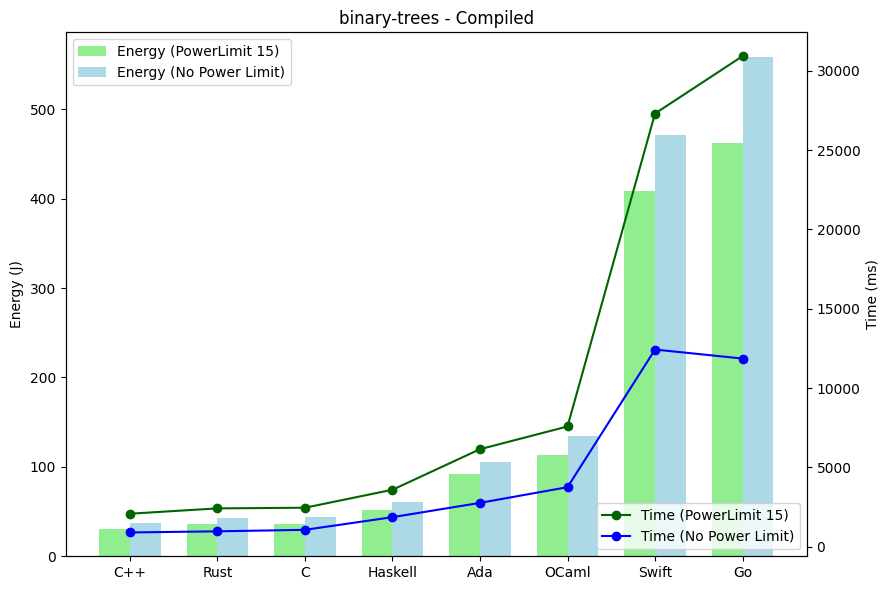

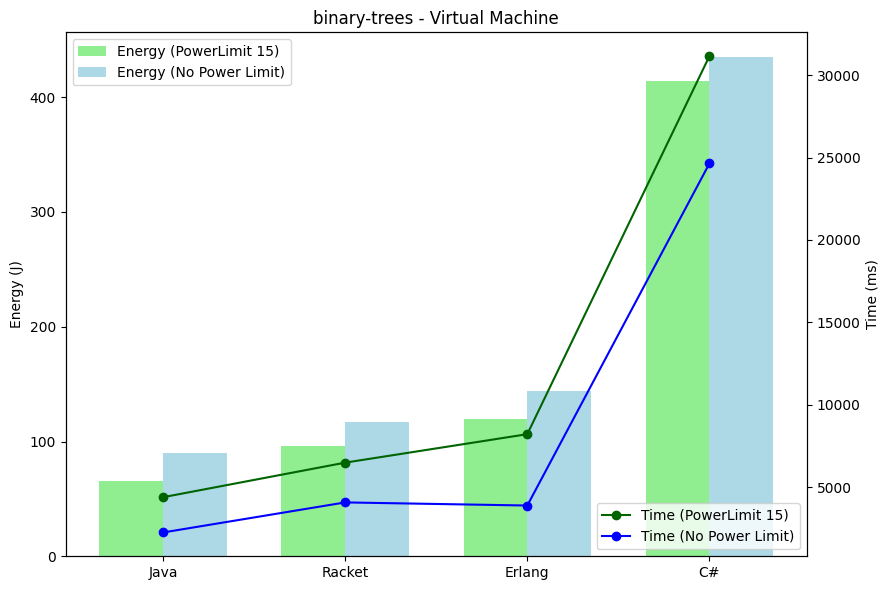

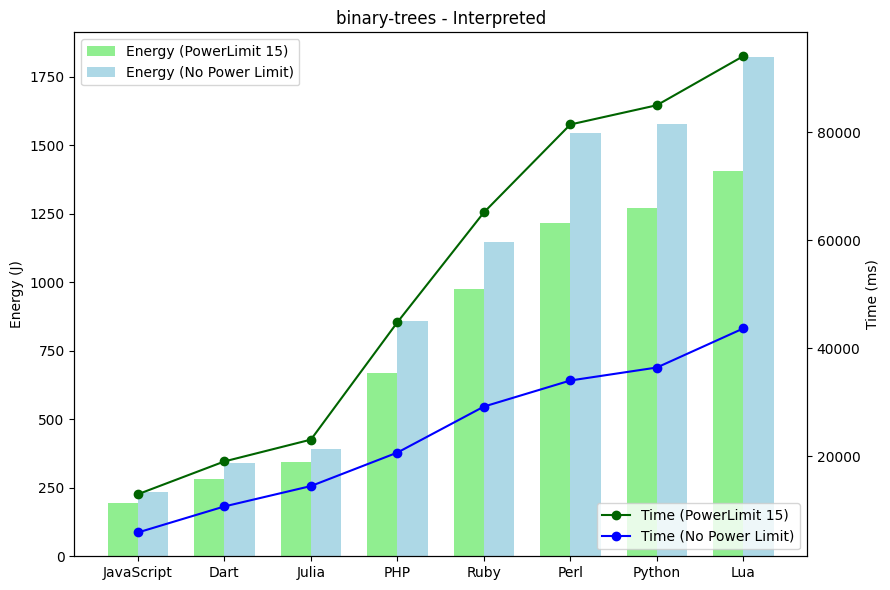

In [105]:
# Separate data by Type and PowerLimit
compiled_15_data = singleProblemDF[(singleProblemDF['Type'] == 'Compiled') & (singleProblemDF['PowerLimit'] == 15)]
compiled_minus_1_data = singleProblemDF[(singleProblemDF['Type'] == 'Compiled') & (singleProblemDF['PowerLimit'] == -1)]

vm_15_data = singleProblemDF[(singleProblemDF['Type'] == 'Virtual Machine') & (singleProblemDF['PowerLimit'] == 15)]
vm_minus_1_data = singleProblemDF[(singleProblemDF['Type'] == 'Virtual Machine') & (singleProblemDF['PowerLimit'] == -1)]

interpreted_15_data = singleProblemDF[(singleProblemDF['Type'] == 'Interpreted') & (singleProblemDF['PowerLimit'] == 15)]
interpreted_minus_1_data = singleProblemDF[(singleProblemDF['Type'] == 'Interpreted') & (singleProblemDF['PowerLimit'] == -1)]

# Function to plot data
def plot_data(energy_15, time_15, energy_minus_1, time_minus_1, label):
    fig, ax = plt.subplots(figsize=(9, 6))
    x = np.arange(len(energy_15))
    width = 0.35

    ax.bar(x - width/2, energy_15['Energy (J)'], width, color='lightgreen', label='Energy (PowerLimit 15)')
    ax.bar(x + width/2, energy_minus_1['Energy (J)'], width, color='lightblue', label='Energy (No Power Limit)')
    
    ax2 = ax.twinx()
    ax2.plot(x, energy_15['Time (ms)'], color='darkgreen', marker='o', label='Time (PowerLimit 15)')
    ax2.plot(x, time_minus_1['Time (ms)'], color='blue', marker='o', label='Time (No Power Limit)')
    
    ax.set_xticks(x)
    ax.set_xticklabels(energy_15['Language'])
    ax.set_ylabel('Energy (J)')
    ax2.set_ylabel('Time (ms)')
    ax.set_title(label)
    ax.legend(loc='upper left')
    ax2.legend(loc='lower right')  # Adjusting legend position

    plt.tight_layout()
    plt.show()

# Plotting and displaying images
plot_data(compiled_15_data, compiled_15_data, compiled_minus_1_data, compiled_minus_1_data, f'{problem} - Compiled')
plot_data(vm_15_data, vm_15_data, vm_minus_1_data, vm_minus_1_data, f'{problem} - Virtual Machine')
plot_data(interpreted_15_data, interpreted_15_data, interpreted_minus_1_data, interpreted_minus_1_data, f'{problem} - Interpreted')

In [106]:
singleProblemDF_dict = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in singleProblemDF.groupby('Type'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    singleProblemDF_dict[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in singleProblemDF_dict.items():
    print(f"Program: {program}")
    print(sorted_df.drop(columns=['Program']))
    print("\n")

Program: Compiled
   Language  PowerLimit  Energy (J)     Time (ms)      Type
0       C++          15   31.039503   2075.428571  Compiled
1      Rust          15   36.037733   2411.000000  Compiled
2         C          15   36.662851   2452.928571  Compiled
3       C++          -1   37.163199    893.000000  Compiled
4      Rust          -1   42.265533    964.571429  Compiled
5         C          -1   43.835545   1058.785714  Compiled
6   Haskell          15   51.612270   3586.571429  Compiled
7   Haskell          -1   60.254364   1857.642857  Compiled
8       Ada          15   91.781001   6143.857143  Compiled
9       Ada          -1  105.951338   2758.571429  Compiled
10    OCaml          15  113.276838   7577.285714  Compiled
11    OCaml          -1  134.281010   3748.000000  Compiled
12    Swift          15  408.260991  27308.500000  Compiled
13       Go          15  462.370623  30927.785714  Compiled
14    Swift          -1  471.039804  12427.142857  Compiled
15       Go          -

### Gráficos finais com somas

In [107]:
#dfSomasPrograms = dfRanking.groupby(['Language' , 'Program' ,'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()
dfSomasPrograms = dfRanking.groupby(['Language' ,'PowerLimit']).agg({'Energy (J)': 'sum', 'Time (ms)': 'sum'}).reset_index()
dfSomasPrograms.head(5)

,Language,PowerLimit,Energy (J),Time (ms)
0,Ada,-1,997.213915,31113.785714
1,Ada,15,881.105059,58956.500000
2,C,-1,380.009208,11349.285714
3,C,15,330.730360,22108.428571
4,C#,-1,986.920340,42667.857143


In [108]:
dataset_power_no_limit = dfSomasPrograms[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
dataset_power_limit_15 = dfSomasPrograms[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\2430238798.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_power_no_limit = dfSomasPrograms[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\2430238798.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_power_limit_15 = dfSomasPrograms[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])


#### Gráficos finais com somas (no limit)

In [109]:
dataset_power_no_limit = dataset_power_no_limit.sort_values(by='Energy (J)').reset_index(drop=True)
dataset_power_no_limit.head(20)
#TODO

,Language,Energy (J),Time (ms)
0,C++,375.565831,1.170964e+04
1,C,380.009208,1.134929e+04
2,Rust,709.621512,2.009071e+04
3,C#,986.920340,4.266786e+04
4,Ada,997.213915,3.111379e+04
5,Java,1183.926291,3.275693e+04
6,Julia,1308.099622,6.058486e+04
7,OCaml,1534.605146,4.911057e+04
8,Go,1581.946520,4.115157e+04
9,JavaScript,1669.989323,5.085271e+04


In [110]:
# Define the reference values for Energy and Time
reference_energy = dataset_power_no_limit.loc[0, 'Energy (J)']
reference_time = dataset_power_no_limit.loc[0, 'Time (ms)']

# Normalize Energy and Time columns
dataset_power_no_limit_normalized = dataset_power_no_limit.copy()
dataset_power_no_limit_normalized['Energy Normalized'] = dataset_power_no_limit_normalized['Energy (J)'] / reference_energy
dataset_power_no_limit_normalized['Time Normalized'] = dataset_power_no_limit_normalized['Time (ms)'] / reference_time
dataset_power_no_limit_normalized = dataset_power_no_limit_normalized.drop(columns=['Energy (J)','Time (ms)'])
dataset_power_no_limit_normalized.head(20)
#TODO

,Language,Energy Normalized,Time Normalized
0,C++,1.000000,1.000000
1,C,1.011831,0.969226
2,Rust,1.889473,1.715741
3,C#,2.627823,3.643822
4,Ada,2.655231,2.657108
5,Java,3.152380,2.797432
6,Julia,3.483010,5.173929
7,OCaml,4.086115,4.194028
8,Go,4.212168,3.514332
9,JavaScript,4.446595,4.342807


#### Gráficos finais com somas (limit = 15)

In [111]:
dataset_power_limit_15 = dataset_power_limit_15.sort_values(by='Energy (J)').reset_index(drop=True)
dataset_power_limit_15.head(20)

,Language,Energy (J),Time (ms)
0,C,330.730360,2.210843e+04
1,C++,331.092826,2.213257e+04
2,Rust,642.912035,4.298686e+04
3,Ada,881.105059,5.895650e+04
4,C#,904.564039,6.410493e+04
5,Java,1028.237470,6.878543e+04
6,Julia,1225.345947,8.199821e+04
7,OCaml,1324.824506,8.860921e+04
8,Go,1357.757086,9.081486e+04
9,JavaScript,1440.615361,9.640971e+04


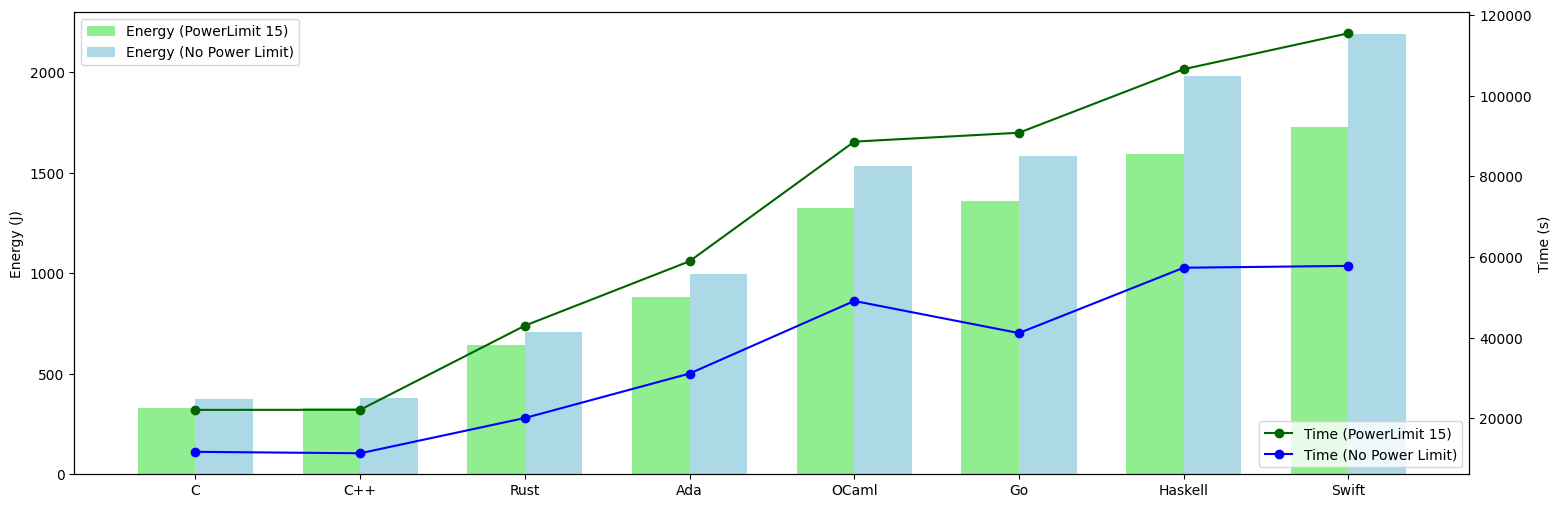

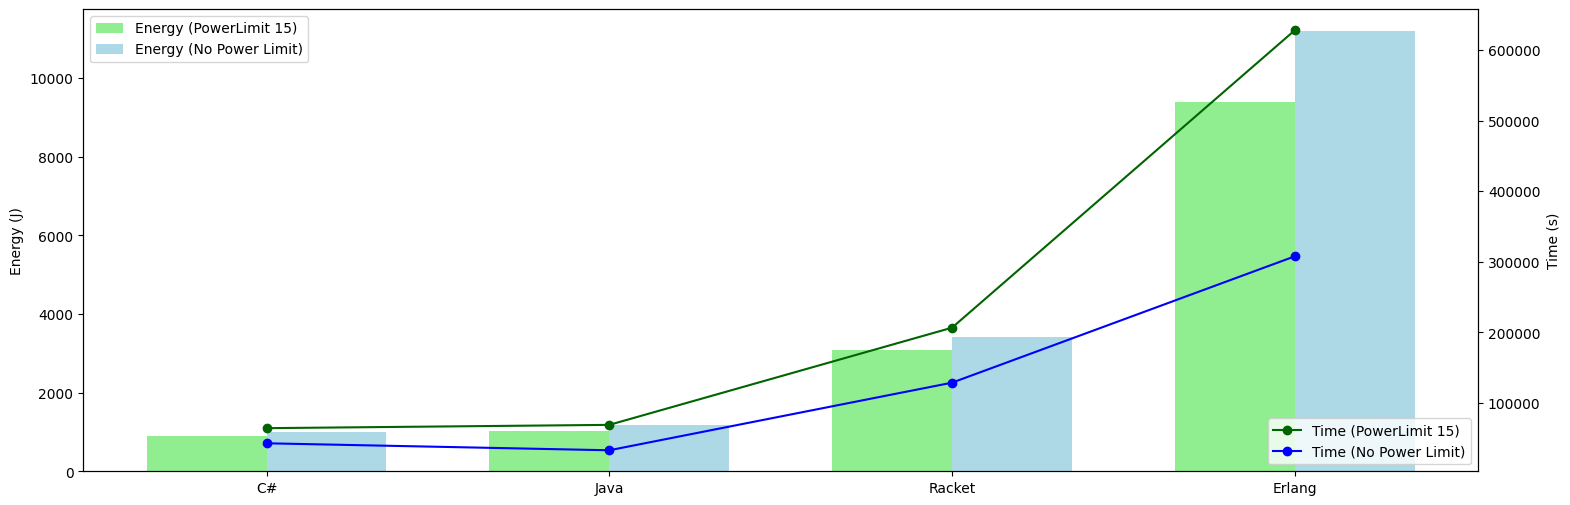

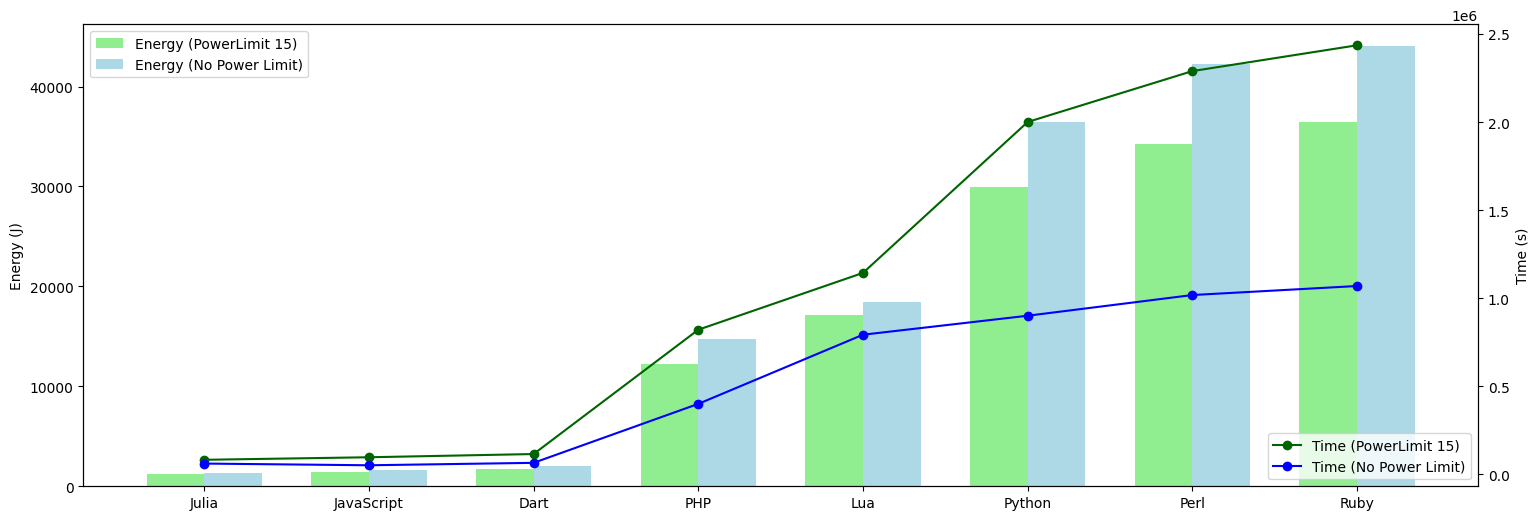

In [112]:
#sabicao
dataset_power_no_limit['Type'] = "undefined"
dataset_power_limit_15['Type'] = "undefined"

# Categorize languages by type
compiled_languages = ['Ada', 'C', 'C++', 'Go', 'Haskell', 'OCaml', 'Rust', 'Swift']
interpreted_languages = ['Dart', 'JavaScript', 'Lua', 'Perl', 'PHP', 'Python', 'Ruby', 'Julia']
vm_languages = ['C#', 'Erlang', 'Java', 'Racket']

dataset_power_no_limit.loc[dataset_power_no_limit['Language'].isin(compiled_languages), 'Type'] = "Compiled"
dataset_power_no_limit.loc[dataset_power_no_limit['Language'].isin(interpreted_languages), 'Type'] = "Interpreted"
dataset_power_no_limit.loc[dataset_power_no_limit['Language'].isin(vm_languages), 'Type'] = "Virtual Machine"
dataset_power_limit_15.loc[dataset_power_limit_15['Language'].isin(compiled_languages), 'Type'] = "Compiled"
dataset_power_limit_15.loc[dataset_power_limit_15['Language'].isin(interpreted_languages), 'Type'] = "Interpreted"
dataset_power_limit_15.loc[dataset_power_limit_15['Language'].isin(vm_languages), 'Type'] = "Virtual Machine"

# Separate data by Type and PowerLimit
compiled_15_data = dataset_power_limit_15[(dataset_power_limit_15['Type'] == 'Compiled')]
compiled_minus_1_data = dataset_power_no_limit[(dataset_power_no_limit['Type'] == 'Compiled')]

vm_15_data = dataset_power_limit_15[(dataset_power_limit_15['Type'] == 'Virtual Machine')]
vm_minus_1_data = dataset_power_no_limit[(dataset_power_no_limit['Type'] == 'Virtual Machine')]

interpreted_15_data = dataset_power_limit_15[(dataset_power_limit_15['Type'] == 'Interpreted')]
interpreted_minus_1_data = dataset_power_no_limit[(dataset_power_no_limit['Type'] == 'Interpreted')]

# Function to plot data
def plot_data(ax, energy_15, time_15, energy_minus_1, time_minus_1, label):
    x = np.arange(len(energy_15))
    width = 0.35

    ax.bar(x - width/2, energy_15['Energy (J)'], width, color='lightgreen', label='Energy (PowerLimit 15)')
    ax.bar(x + width/2, energy_minus_1['Energy (J)'], width, color='lightblue', label='Energy (No Power Limit)')
    
    ax2 = ax.twinx()
    ax2.plot(x, energy_15['Time (ms)'], color='darkgreen', marker='o', label='Time (PowerLimit 15)')
    ax2.plot(x, time_minus_1['Time (ms)'], color='blue', marker='o', label='Time (No Power Limit)')
    
    ax.set_xticks(x)
    ax.set_xticklabels(energy_15['Language'])
    ax.set_ylabel('Energy (J)')
    ax2.set_ylabel('Time (s)')
    #ax.set_title(label)
    ax.legend(loc='upper left')
    ax2.legend(loc='lower right')  # Adjusting legend position

# Create three separate figures
fig1, ax1 = plt.subplots(figsize=(18, 6))
fig2, ax2 = plt.subplots(figsize=(18, 6))
fig3, ax3 = plt.subplots(figsize=(18, 6))

# Plot data for Compiled
plot_data(ax1, compiled_15_data, compiled_15_data, compiled_minus_1_data, compiled_minus_1_data, f'CLBG problems - Compiled')

# Plot data for Virtual Machine
plot_data(ax2, vm_15_data, vm_15_data, vm_minus_1_data, vm_minus_1_data, f'CLBG problems - Virtual Machine')

# Plot data for Interpreted
plot_data(ax3, interpreted_15_data, interpreted_15_data, interpreted_minus_1_data, interpreted_minus_1_data, f'CLBG problems - Interpreted')

# Show the plots
plt.show()

In [113]:
result_df = []
#  Iterate over languages in the program
for language in dataset_power_limit_15['Language']:
    # Extract data for the specific language in both dictionaries
    row_df1 = dataset_power_limit_15[dataset_power_limit_15['Language'] == language]
    row_df2 = dataset_power_no_limit[dataset_power_no_limit['Language'] == language]

    # Calculate the differences
    position_changes = row_df1.index[0] - row_df2.index[0]
    energy_difference = row_df1['Energy (J)'].iloc[0] - row_df2['Energy (J)'].iloc[0]
    time_difference = row_df1['Time (ms)'].iloc[0] - row_df2['Time (ms)'].iloc[0]
    # Append the results to the comparison list
    result_df.append({
        'Language': language,
        'Energy (J)': row_df1['Energy (J)'].iloc[0],
        'Time (ms)': row_df1['Time (ms)'].iloc[0],
        'Position Changes': position_changes,
        'Energy Difference (J)': energy_difference,
        'Energy Difference %': energy_difference/row_df2['Energy (J)'].iloc[0]*100,
        'Time Difference (ms)': time_difference,
        'Time Difference %': time_difference/row_df2['Time (ms)'].iloc[0]*100
    })

# Convert the list of dictionaries into a DataFrame
result_df = pd.DataFrame(result_df)

# Display the comparison results
result_df.head(20)
#TODO

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,330.730360,2.210843e+04,-1,-49.278848,-12.967804,1.075914e+04,94.800176
1,C++,331.092826,2.213257e+04,1,-44.473005,-11.841600,1.042293e+04,89.011498
2,Rust,642.912035,4.298686e+04,0,-66.709477,-9.400712,2.289614e+04,113.963807
3,Ada,881.105059,5.895650e+04,-1,-116.108856,-11.643325,2.784271e+04,89.486746
4,C#,904.564039,6.410493e+04,1,-82.356301,-8.344777,2.143707e+04,50.241734
5,Java,1028.237470,6.878543e+04,0,-155.688821,-13.150212,3.602850e+04,109.987418
6,Julia,1225.345947,8.199821e+04,0,-82.753675,-6.326252,2.141336e+04,35.344405
7,OCaml,1324.824506,8.860921e+04,0,-209.780640,-13.670008,3.949864e+04,80.427985
8,Go,1357.757086,9.081486e+04,0,-224.189434,-14.171745,4.966329e+04,120.683827
9,JavaScript,1440.615361,9.640971e+04,0,-229.373962,-13.735056,4.555700e+04,89.586172


In [114]:
result_df = []
#  Iterate over languages in the program
for language in dataset_power_limit_15['Language']:
    # Extract data for the specific language in both dictionaries
    row_df1 = dataset_power_limit_15[dataset_power_limit_15['Language'] == language]
    row_df2 = dataset_power_no_limit[dataset_power_no_limit['Language'] == language]

    # Calculate the differences
    position_changes = row_df1.index[0] - row_df2.index[0]
    energy_difference = row_df1['Energy (J)'].iloc[0] - row_df2['Energy (J)'].iloc[0]
    time_difference = row_df1['Time (ms)'].iloc[0] - row_df2['Time (ms)'].iloc[0]
    # Append the results to the comparison list
    result_df.append({
        'Language': language,
        'Energy (J)': row_df1['Energy (J)'].iloc[0],
        'Time (ms)': row_df1['Time (ms)'].iloc[0],
        'Position Changes': position_changes,
        'Energy Difference (J)': energy_difference,
        'Energy Difference %': energy_difference/row_df2['Energy (J)'].iloc[0]*100,
        'Time Difference (ms)': time_difference,
        'Time Difference %': time_difference/row_df2['Time (ms)'].iloc[0]*100
    })

# Convert the list of dictionaries into a DataFrame
result_df = pd.DataFrame(result_df)

# Display the comparison results
result_df.head(20)
#TODO

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,330.730360,2.210843e+04,-1,-49.278848,-12.967804,1.075914e+04,94.800176
1,C++,331.092826,2.213257e+04,1,-44.473005,-11.841600,1.042293e+04,89.011498
2,Rust,642.912035,4.298686e+04,0,-66.709477,-9.400712,2.289614e+04,113.963807
3,Ada,881.105059,5.895650e+04,-1,-116.108856,-11.643325,2.784271e+04,89.486746
4,C#,904.564039,6.410493e+04,1,-82.356301,-8.344777,2.143707e+04,50.241734
5,Java,1028.237470,6.878543e+04,0,-155.688821,-13.150212,3.602850e+04,109.987418
6,Julia,1225.345947,8.199821e+04,0,-82.753675,-6.326252,2.141336e+04,35.344405
7,OCaml,1324.824506,8.860921e+04,0,-209.780640,-13.670008,3.949864e+04,80.427985
8,Go,1357.757086,9.081486e+04,0,-224.189434,-14.171745,4.966329e+04,120.683827
9,JavaScript,1440.615361,9.640971e+04,0,-229.373962,-13.735056,4.555700e+04,89.586172


In [115]:
# Define the reference values for Energy and Time
reference_energy = result_df.loc[0, 'Energy (J)']
reference_time = result_df.loc[0, 'Time (ms)']

# Normalize Energy and Time columns
result_df_normalized = result_df.copy()
result_df_normalized['Energy (J)'] = result_df_normalized['Energy (J)'] / reference_energy
result_df_normalized['Time (ms)'] = result_df_normalized['Time (ms)'] / reference_time
result_df_normalized.head(20)
#TODO

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,1.000000,1.000000,-1,-49.278848,-12.967804,1.075914e+04,94.800176
1,C++,1.001096,1.001092,1,-44.473005,-11.841600,1.042293e+04,89.011498
2,Rust,1.943916,1.944365,0,-66.709477,-9.400712,2.289614e+04,113.963807
3,Ada,2.664119,2.666698,-1,-116.108856,-11.643325,2.784271e+04,89.486746
4,C#,2.735050,2.899570,1,-82.356301,-8.344777,2.143707e+04,50.241734
5,Java,3.108990,3.111276,0,-155.688821,-13.150212,3.602850e+04,109.987418
6,Julia,3.704970,3.708912,0,-82.753675,-6.326252,2.141336e+04,35.344405
7,OCaml,4.005754,4.007938,0,-209.780640,-13.670008,3.949864e+04,80.427985
8,Go,4.105329,4.107703,0,-224.189434,-14.171745,4.966329e+04,120.683827
9,JavaScript,4.355861,4.360767,0,-229.373962,-13.735056,4.555700e+04,89.586172


In [116]:
result_df = result_df.sort_values(by='Energy Difference %')
result_df.head(20)

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
10,Haskell,1590.383418,1.065689e+05,-2,-597.113974,-27.296671,4.876157e+04,84.351948
18,Perl,34232.888894,2.289864e+06,0,-7979.467255,-18.903155,1.272060e+06,124.980727
17,Python,29912.132834,2.000838e+06,0,-6562.492972,-17.991940,1.100536e+06,122.240756
19,Ruby,36424.086465,2.436441e+06,0,-7608.353228,-17.278973,1.367355e+06,127.899455
15,PHP,12271.254307,8.208522e+05,0,-2487.354017,-16.853581,4.212072e+05,105.395342
14,Erlang,9385.789437,6.282122e+05,0,-1805.443512,-16.132660,3.204828e+05,104.144341
11,Dart,1713.390939,1.146926e+05,0,-326.841854,-16.019831,4.997264e+04,77.213687
8,Go,1357.757086,9.081486e+04,0,-224.189434,-14.171745,4.966329e+04,120.683827
9,JavaScript,1440.615361,9.640971e+04,0,-229.373962,-13.735056,4.555700e+04,89.586172
7,OCaml,1324.824506,8.860921e+04,0,-209.780640,-13.670008,3.949864e+04,80.427985


### Gráficos lindos

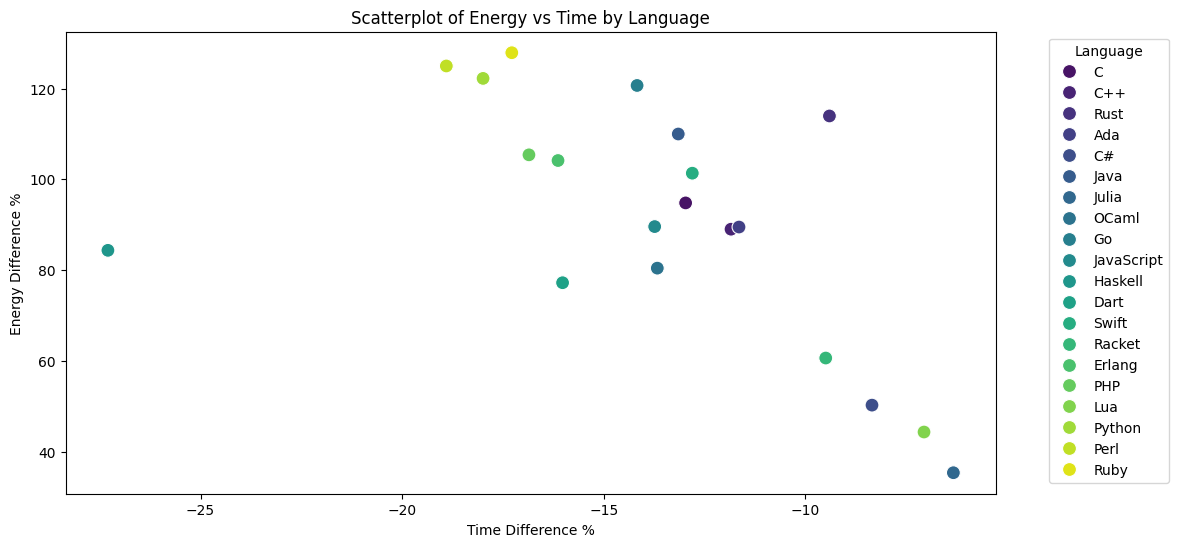

In [117]:
import seaborn as sns
# Criar o scatterplot
plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(y='Time Difference %', x='Energy Difference %', hue='Language', data=result_df_normalized, s=100, palette='viridis')

# Adicionar rótulos e título
plt.xlabel('Time Difference %')
plt.ylabel('Energy Difference %')
plt.title('Scatterplot of Energy vs Time by Language')

# Adicionar legenda
scatter_plot.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3854658300.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Language', y='Energy Difference %', data=result_df_normalized, palette='viridis')


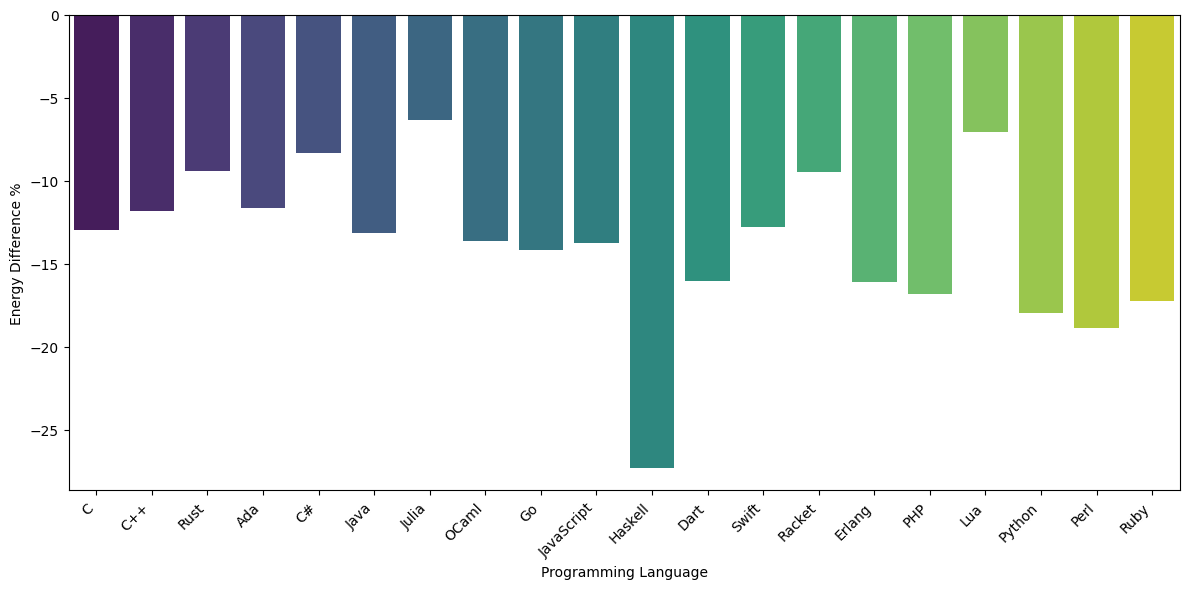

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar o barplot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Language', y='Energy Difference %', data=result_df_normalized, palette='viridis')

# Adicionar rótulos e título
plt.xlabel('Programming Language')
plt.ylabel('Energy Difference %')
#plt.title('Percentual energy difference by programming language')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()
#TODO

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3113866677.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Language', y='Time Difference %', data=result_df_normalized, palette='viridis')


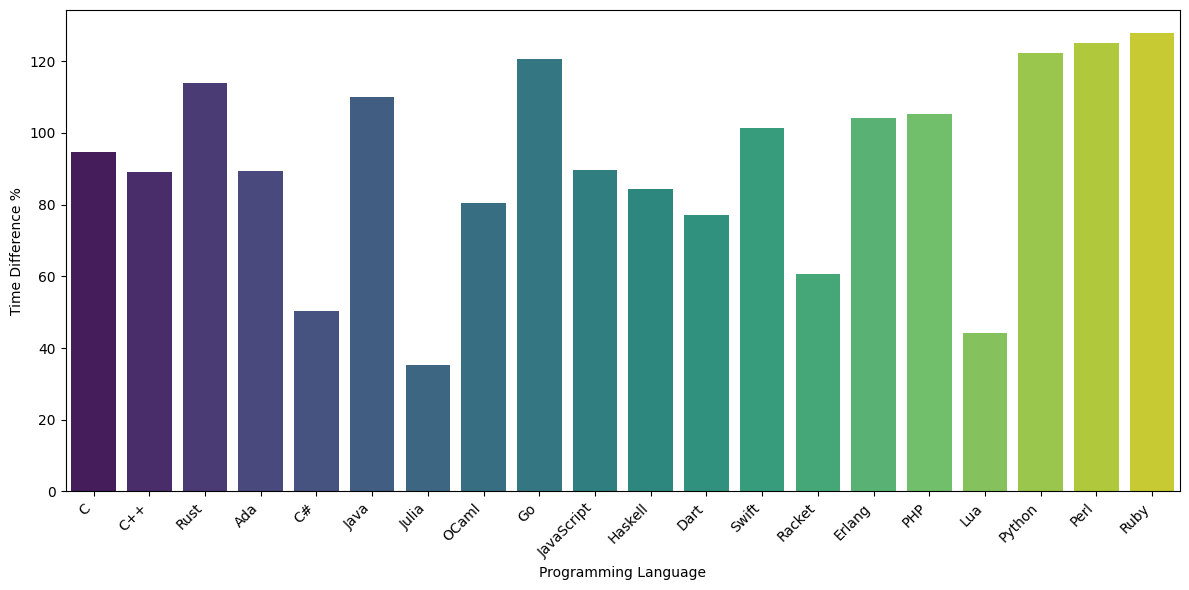

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar o barplot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Language', y='Time Difference %', data=result_df_normalized, palette='viridis')

# Adicionar rótulos e título
plt.xlabel('Programming Language')
plt.ylabel('Time Difference %')
#plt.title('Percentual time difference by programming language')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()
#TODO

# Recuperação de valores

In [120]:
dfTratamento = df.drop(['GPU', 'Core','DRAM'], axis=1)
dfTratamento['PowerLimit'].replace(-1, 999, inplace=True)
dfTratamento = dfTratamento.loc[dfTratamento['Package'] <= 0]
dfTratamento = dfTratamento.loc[dfTratamento['PowerLimit'] == 25]

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


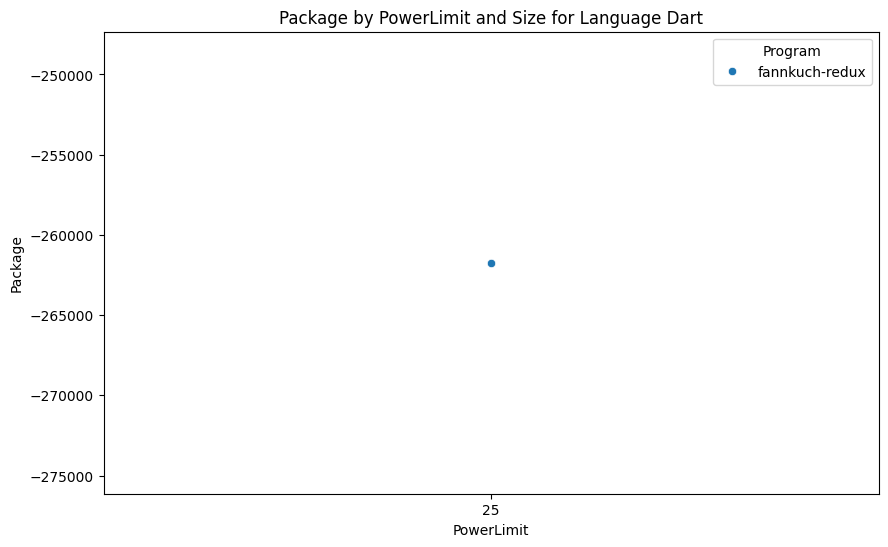

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


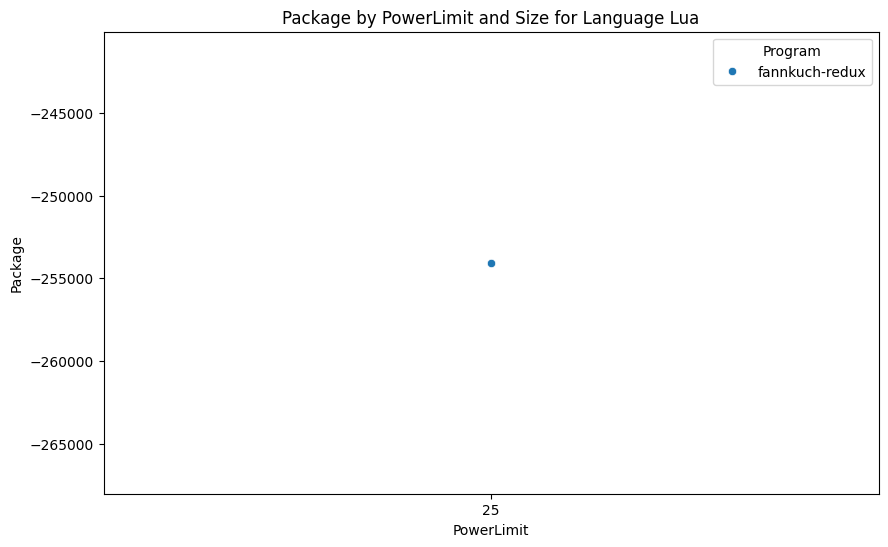

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


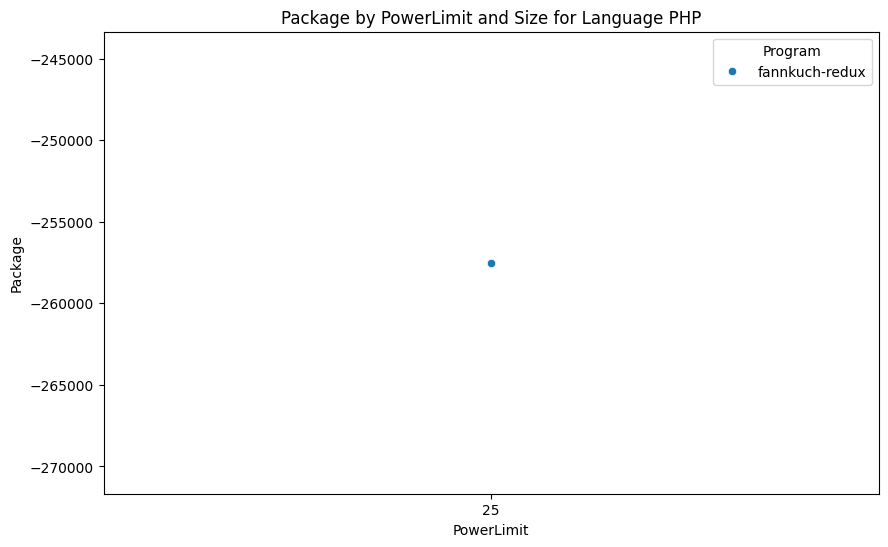

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


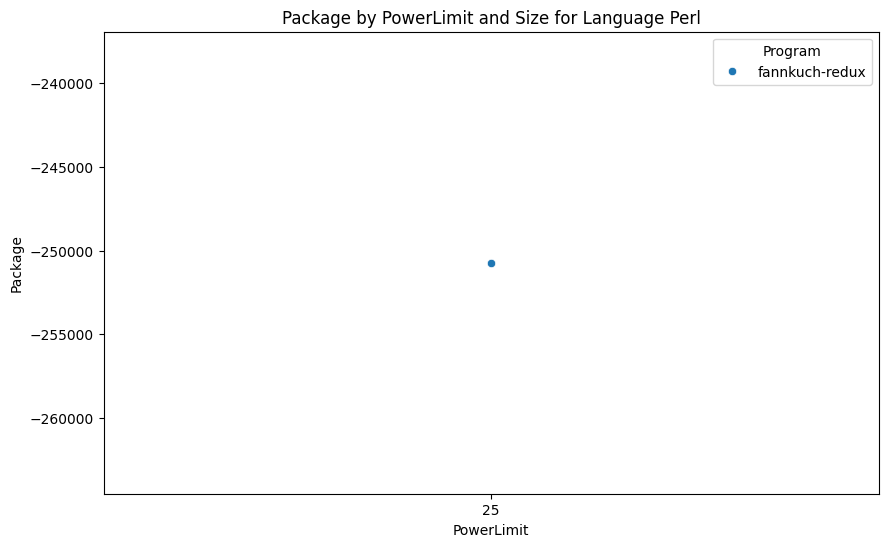

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


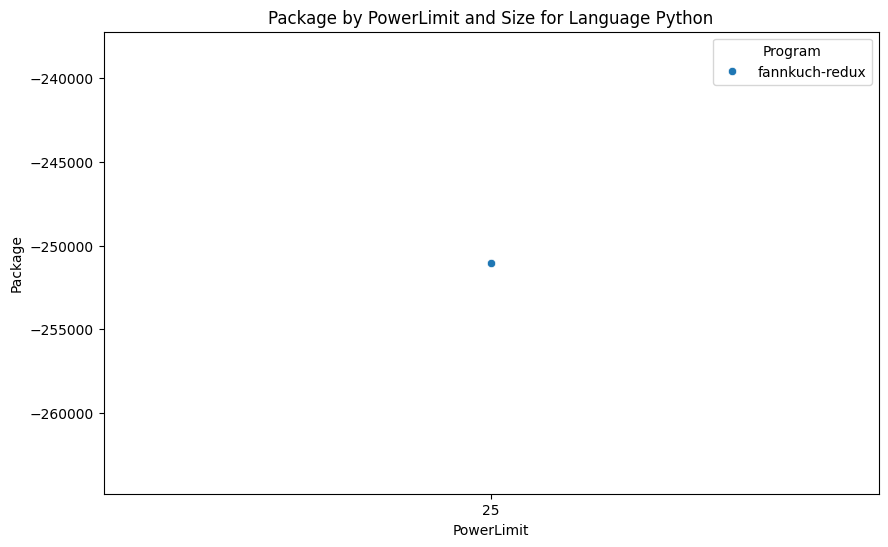

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

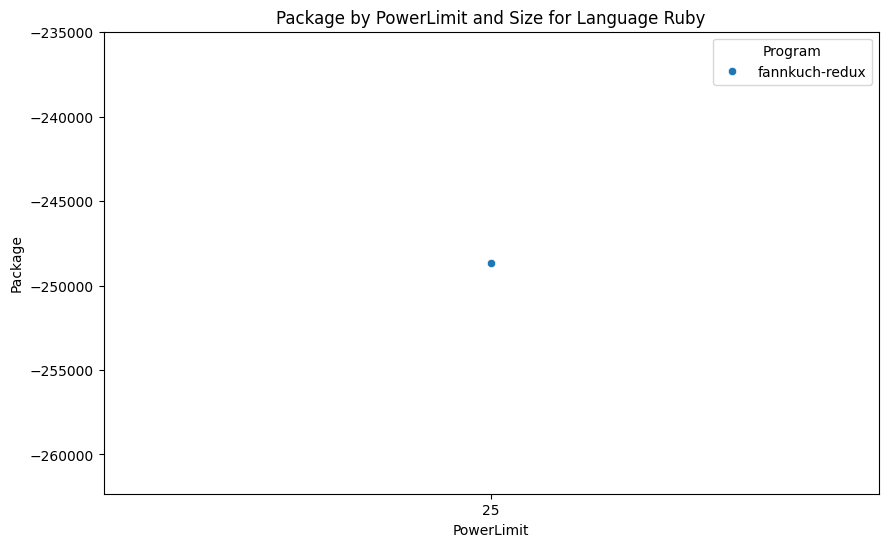

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

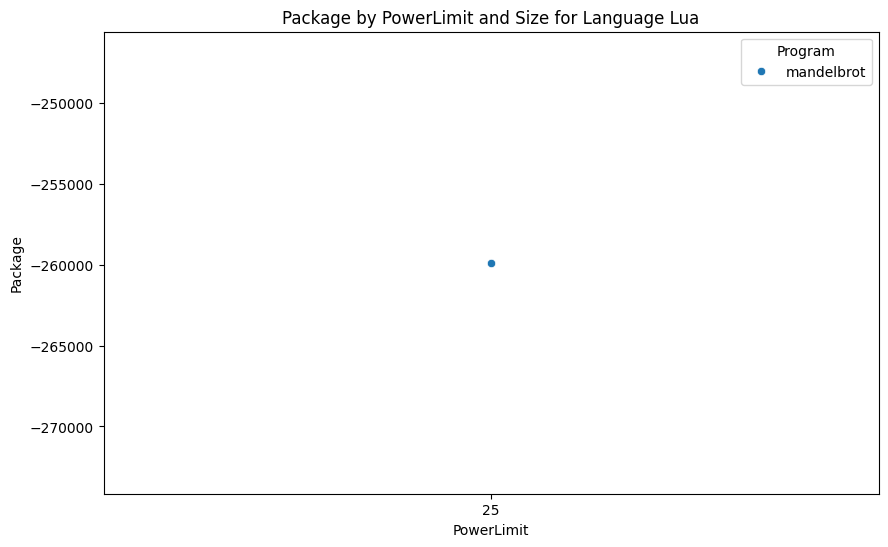

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

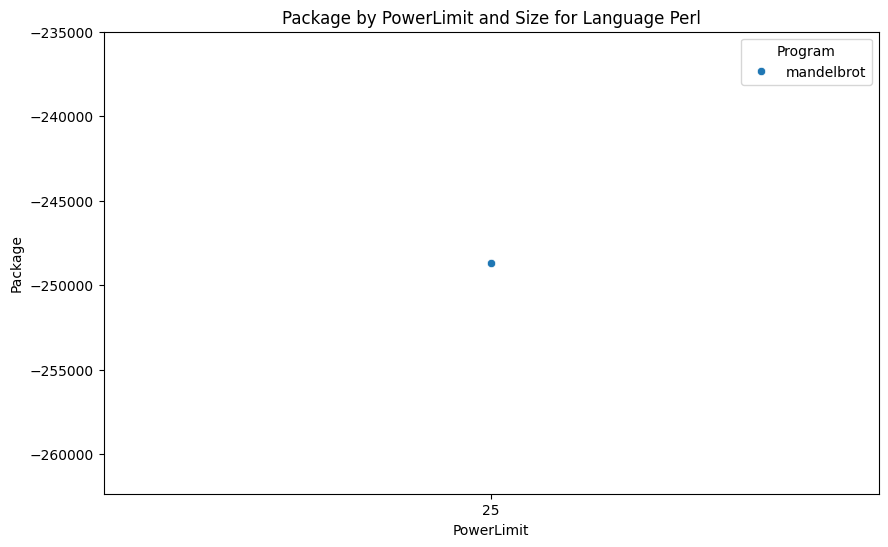

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

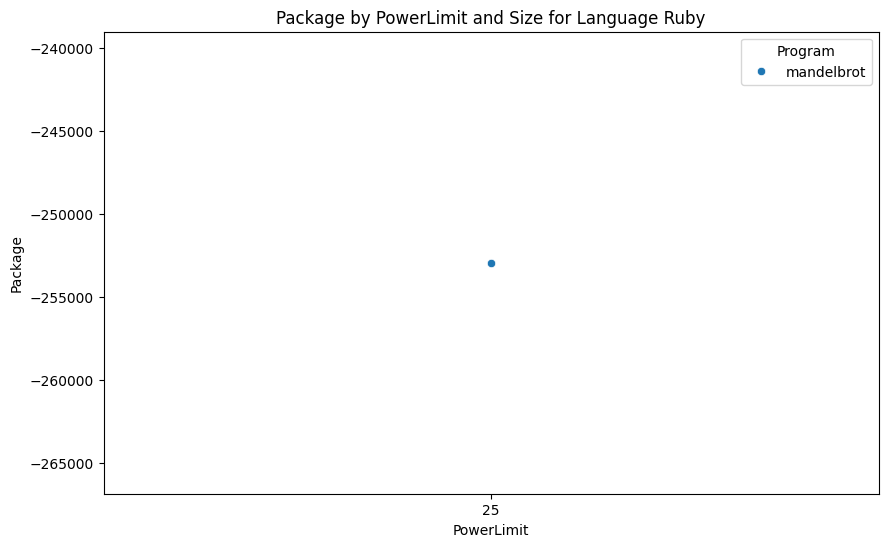

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

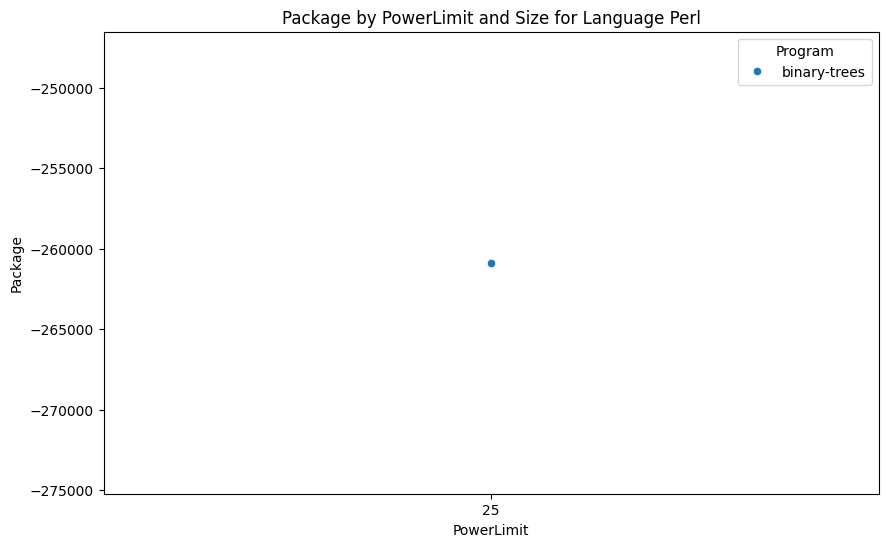

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

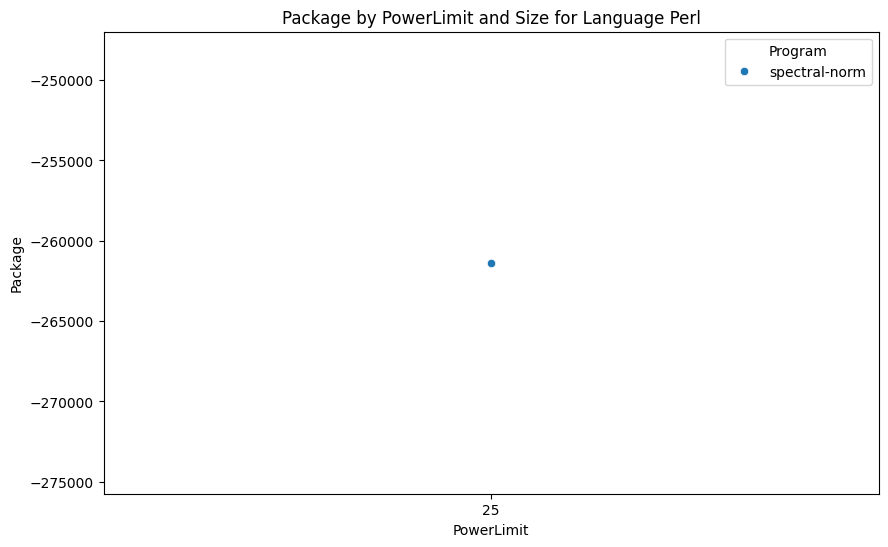

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

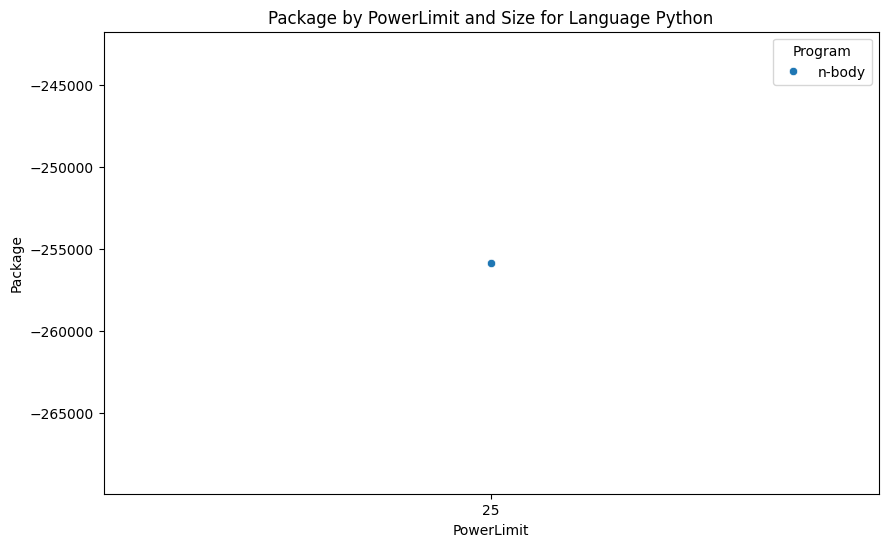

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

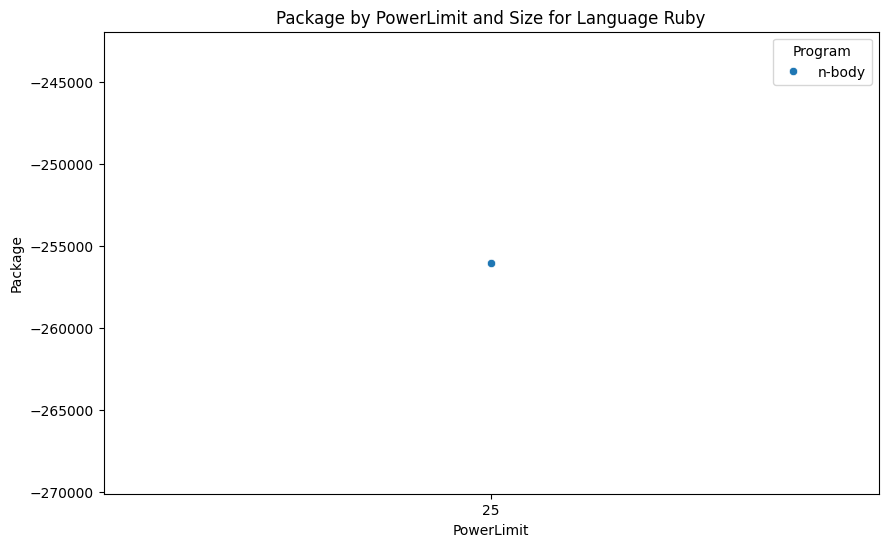

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21892\3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

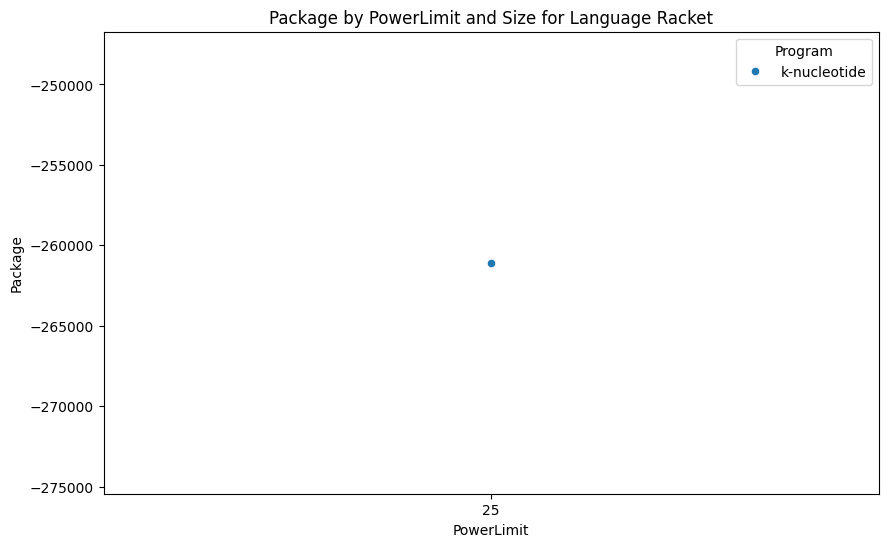

<Figure size 1000x600 with 0 Axes>

In [121]:
import matplotlib.pyplot as plt
import seaborn as sea

# Columns for comparison
#columns = ["Time", "Package", "Memory"]
columns = [ "Package"]
group_column = "PowerLimit"  # Specify the column to group by

# Iterate over the columns
for col in columns:
    programs = dfTratamento['Program'].unique()
    for program in programs:
        languages = dfTratamento['Language'].unique()
        for language in languages:
            plt.figure(figsize=(10, 6))
            
            data_subset = dfTratamento[(dfTratamento['Language'] == language) & (dfTratamento['Program'] == program)]
            if data_subset.shape[0]>0 :
                data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)

                ax = sea.scatterplot(data=data_subset, x=group_column, y=col, hue='Program')  # Add size='Size' parameter

                plt.xlabel(group_column)
                plt.ylabel(col)
                plt.title(f'{col} by {group_column} and Size for Language {language}')

                plt.legend(title='Program')
                plt.show()


### Teste de hipoteses

In [122]:
dfAnalise

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
1,Ada,binary-trees,-1,104.618347,2786.0,30.2,202912.0
4,Ada,binary-trees,-1,104.885132,2784.0,32.2,203208.0
7,Ada,binary-trees,-1,104.973206,2787.0,34.0,202772.0
11,Ada,binary-trees,-1,105.053101,2803.0,35.5,202772.0
3,Ada,binary-trees,-1,105.154663,2731.0,32.5,203136.0
...,...,...,...,...,...,...,...
20895,Swift,spectral-norm,25,41.473877,1663.0,40.0,8272.0
20897,Swift,spectral-norm,25,41.481934,1663.0,39.5,8216.0
20894,Swift,spectral-norm,25,41.497986,1663.0,39.2,8428.0
20881,Swift,spectral-norm,25,41.518494,1664.0,39.5,8272.0


In [123]:
dfAnalise_power_no_limit = dfAnalise[dfAnalise['PowerLimit'] == -1].drop(columns=['PowerLimit'])
dfAnalise_power_limit_15 = dfAnalise[dfAnalise['PowerLimit'] == 15].drop(columns=['PowerLimit'])

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot

package_with_powercap = dfAnalise_power_limit_15['Package']
package_without_powercap = dfAnalise_power_no_limit['Package']


In [128]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(package_with_powercap)
print(f'Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}')
stat2, p_value2 = shapiro(package_without_powercap)
print(f'Shapiro-Wilk Test: Statistic={stat2}, p-value={p_value2}')


Shapiro-Wilk Test: Statistic=0.42696982622146606, p-value=0.0
Shapiro-Wilk Test: Statistic=0.41306012868881226, p-value=0.0


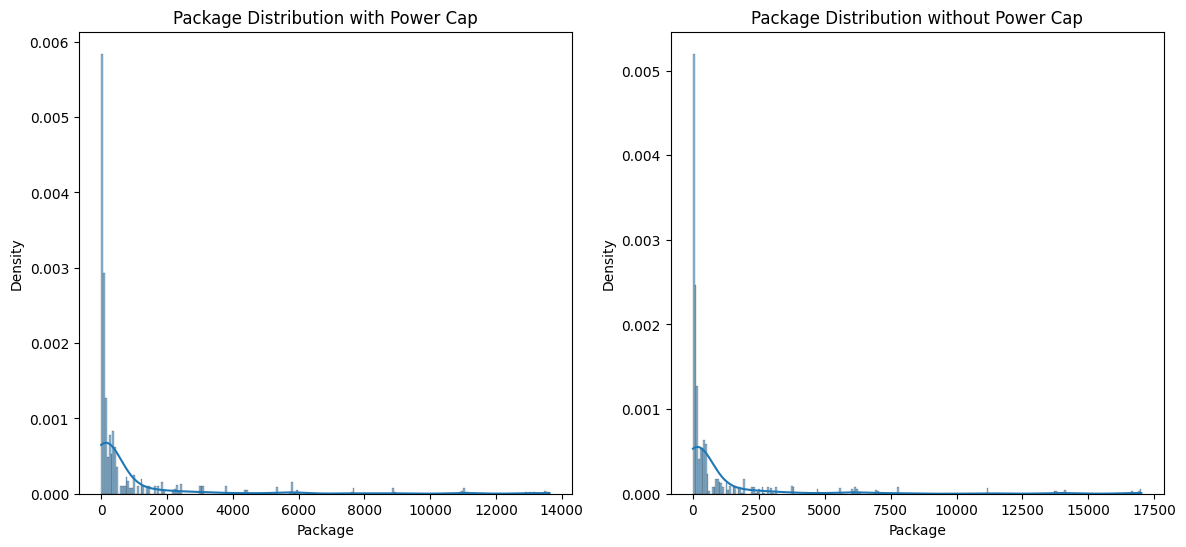

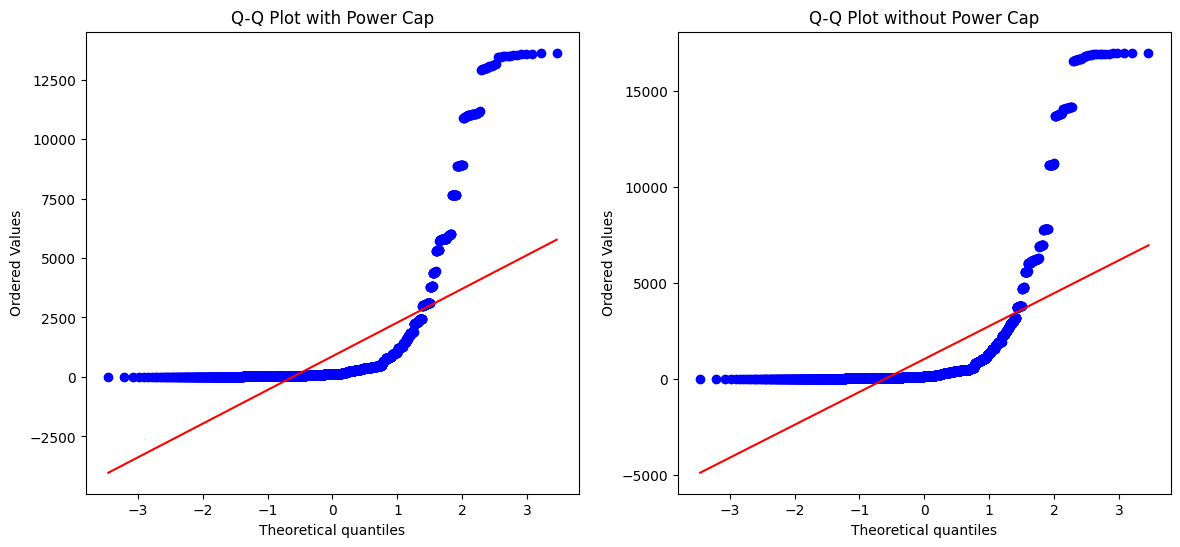

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# Histograma com Curva de Densidade
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(package_with_powercap, kde=True, stat="density")
plt.title('Package Distribution with Power Cap')
plt.subplot(1, 2, 2)
sns.histplot(package_without_powercap, kde=True, stat="density")
plt.title('Package Distribution without Power Cap')
plt.show()

# Q-Q Plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
probplot(package_with_powercap, dist="norm", plot=plt)
plt.title('Q-Q Plot with Power Cap')
plt.subplot(1, 2, 2)
probplot(package_without_powercap, dist="norm", plot=plt)
plt.title('Q-Q Plot without Power Cap')
plt.show()


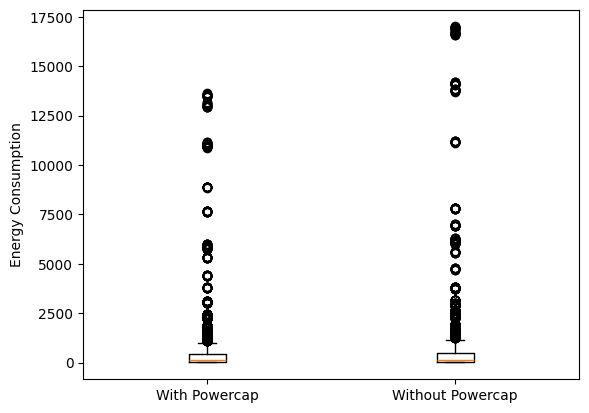

P-value for normality test (with powercap): 0.0
P-value for normality test (without powercap): 0.0
Wilcoxon Signed-Rank Test - statistic: 124371.0, p-value: 0.0
There is a significant difference in energy consumption between the two conditions.


In [136]:
# Visualize the data
plt.boxplot([package_with_powercap, package_without_powercap], labels=['With Powercap', 'Without Powercap'])
plt.ylabel('Energy Consumption')
plt.show()

# Check for normality
stat1, p1 = stats.shapiro(package_with_powercap)
stat2, p2 = stats.shapiro(package_without_powercap)

print(f'P-value for normality test (with powercap): {p1}')
print(f'P-value for normality test (without powercap): {p2}')


w_stat, p_val = stats.wilcoxon(package_with_powercap, package_without_powercap)

print(f'Wilcoxon Signed-Rank Test - statistic: {w_stat}, p-value: {p_val}')

# Interpret the results
if p_val < 0.05:
    print('There is a significant difference in energy consumption between the two conditions.')
else:
    print('There is no significant difference in energy consumption between the two conditions.')